# Домашнее задание 8

Обучить генератор создавать точки, которые будут лежать на графике функции 𝑦=sin(𝑥)𝑥−𝑥10

При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
#импорт необходимых библиотек и модулей
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.utils import save_image, make_grid

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
class Data(Dataset):
    def __init__(self, func, min, max, num):
        self.num = num
        self.x = (max - min) * np.random.random_sample(num) + min
        self.func = func

    def __getitem__(self, idx):
        point = self.x[idx]
        return torch.Tensor([point, self.func(point)])

    def __len__(self):
        return self.num

In [4]:
FUNC = lambda x: np.sin(x)/x - x/10
MIN = -15
MAX = 15
NUM = 10000

In [5]:
data = Data(FUNC, MIN, MAX, NUM)

In [6]:
data[0]

tensor([13.2567, -1.2776])

In [7]:
len(data)

10000

In [8]:
data_loader = DataLoader(data, batch_size = 128, shuffle=True)

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2))

    def forward(self, x):
        output = self.model(x)
        return output

In [10]:
class Discriminator(nn.Module):
    def __init__(self,  hidden_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128,  hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

In [26]:
n_epochs = 100
lr = 0.0001

b1 = 0.5
b2 = 0.999

latent_dim = 1
hidden_dim = 64

In [27]:
generator = Generator(latent_dim, hidden_dim).to(device)
discriminator = Discriminator(hidden_dim).to(device)

In [28]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1, b2)
)

optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(b1, b2)
)

In [29]:
adversarial_loss = torch.nn.BCELoss()

In [30]:
d_loss_history = []
g_loss_history = []
gen_data_list = []
for epoch in range(n_epochs):

    d_loss_mean = 0.0
    g_loss_mean = 0.0

    for data in data_loader:
        batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.Tensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.Tensor(batch_size, 1).fill_(0.0).to(device)
        real_data = data.type(torch.Tensor).to(device)

        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        gen_data = generator(z)

######################  Тренировка дискриминатора    ##########################
        real_pred = discriminator(real_data)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_data)
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        gen_data = generator(z)
        fake_pred = discriminator(gen_data)

        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        d_loss_mean += d_loss.item()
        g_loss_mean += g_loss.item()

######## Отображение процесса обучения и вывод функций потерь ############
    if (epoch + 1) % 10 == 0:
      gen_data_list.append(gen_data.cpu().detach().numpy())
      print(f'Epoch: {epoch + 1}; '\
            f'Discriminator_loss: {round(d_loss_mean / len(data_loader), 3)}; '\
            f'Generator_loss: {round(g_loss_mean / len(data_loader), 3)}')

    d_loss_history.append(d_loss_mean / len(data_loader))
    g_loss_history.append(g_loss_mean / len(data_loader))


Epoch: 10; Discriminator_loss: 0.292; Generator_loss: 2.111
Epoch: 20; Discriminator_loss: 0.439; Generator_loss: 1.308
Epoch: 30; Discriminator_loss: 0.489; Generator_loss: 1.121
Epoch: 40; Discriminator_loss: 0.516; Generator_loss: 1.03
Epoch: 50; Discriminator_loss: 0.557; Generator_loss: 0.937
Epoch: 60; Discriminator_loss: 0.573; Generator_loss: 0.915
Epoch: 70; Discriminator_loss: 0.578; Generator_loss: 0.9
Epoch: 80; Discriminator_loss: 0.581; Generator_loss: 0.881
Epoch: 90; Discriminator_loss: 0.599; Generator_loss: 0.871
Epoch: 100; Discriminator_loss: 0.653; Generator_loss: 0.787


In [31]:
len(gen_data_list)

10

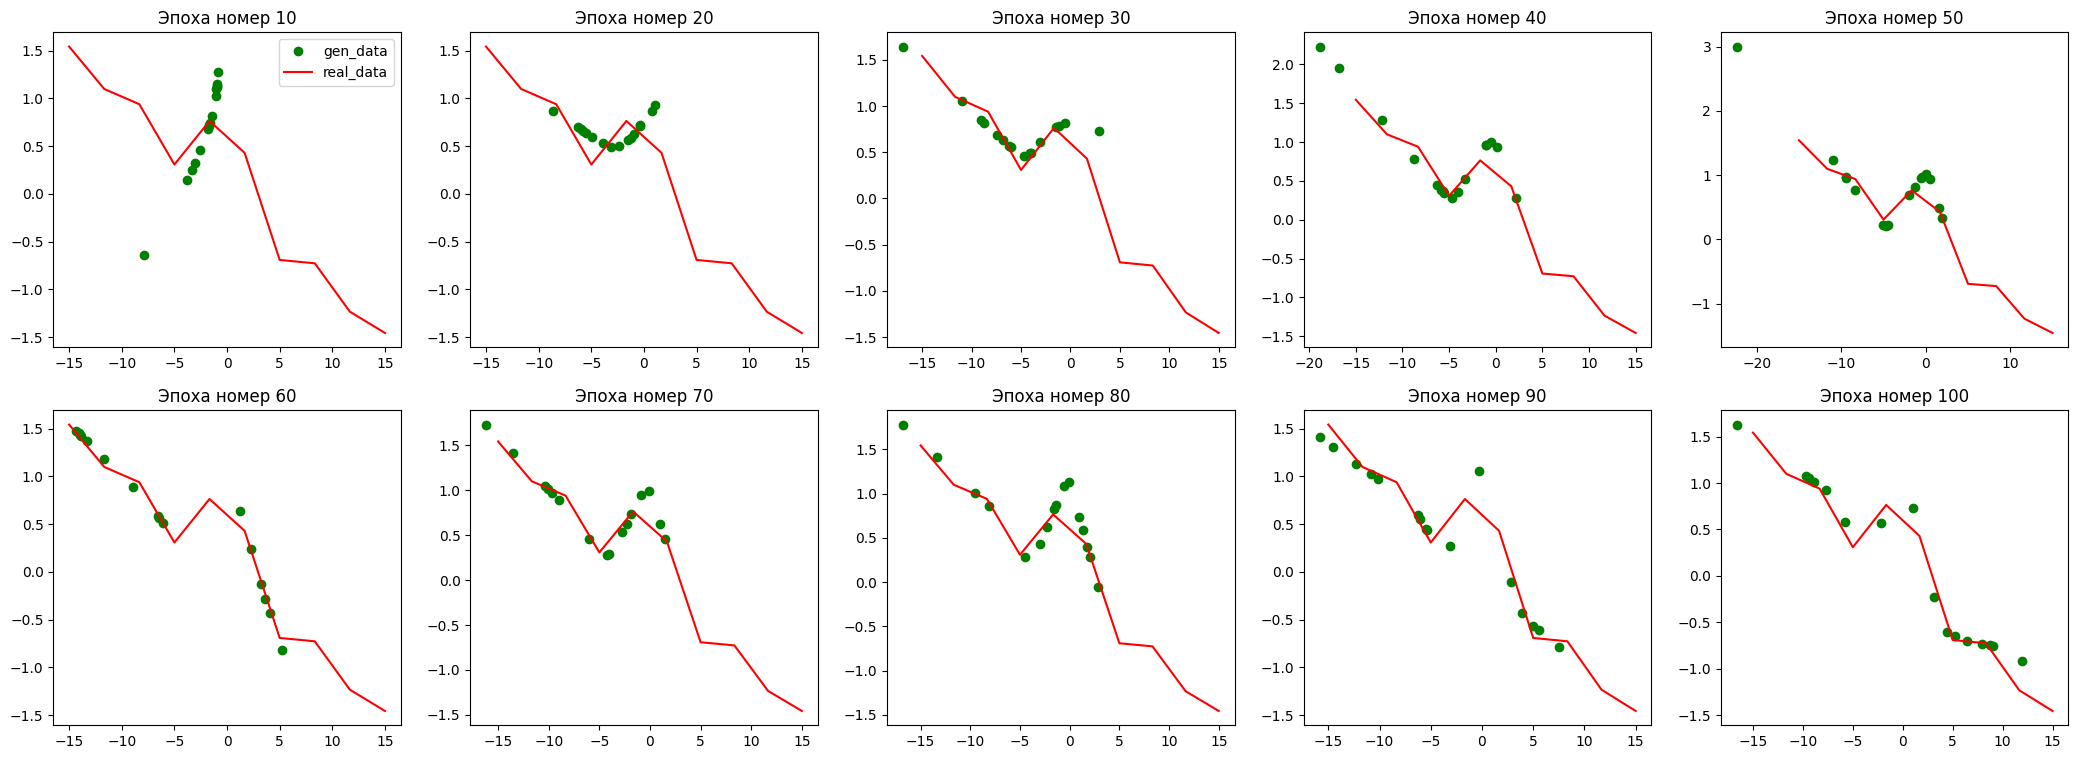

In [60]:
fig, axs = plt.subplots(2, 5, figsize=(26, 9))
real_data_list = [np.linspace(MIN, MAX, 10), FUNC(np.linspace(MIN, MAX, 10))]
for i in range(len(gen_data_list)):
  axs = axs.flatten()
  axs[i].set_title(f'Эпоха номер {(i + 1) * 10}')
  axs[i].plot(gen_data_list[i][:,0], gen_data_list[i][:,1], 'go', label='gen_data')
  axs[i].plot(real_data_list[0], real_data_list[1], 'r', label='real_data')
axs[0].legend()
plt.show()